In [1]:
#
import numpy as np
import os, sys
import matplotlib.pyplot as plt

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg
from cuts import getGeoCuts, get_bgs, flux_to_mag
from QA import getStats, flow

import healpy as hp
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.units as units
import fitsio
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'

#survey = 'south' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'

Nranfiles = 3
patch = None #[174., 186., -3., 2.]
reg = 'desi' #'south', 'north', 'decals', 'des', 'svfields'
dr = 'dr8'
#version = '2.0'
if dr == 'dr9d': Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20
dec_resol_ns = 32.375

# for healpy
hdr          = fits.getheader(dr8pix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

## catalogue

cat = merge_NS(sweep_north='/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/bgstargets-north.npy', 
               extra_north='/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/extra-north_n256.npy', 
               sweep_south='/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/bgstargets-south.npy',
               extra_south='/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/extra-south_n256.npy',
               resolve_DEC=dec_resol_ns)

In [3]:

sweep_n_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/bgstargets-north.npy'
sweep_s_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/bgstargets-south.npy'

extra_n_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/extra-north_n256.npy'
extra_s_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/extra-south_n256.npy'

%time sweep_n = np.load(sweep_n_file)
%time sweep_s = np.load(sweep_s_file)

%time extra_n = np.load(extra_n_file)
%time extra_s = np.load(extra_s_file)

#resolve for north/south and select only BGS targets
bgs_n = ((sweep_n['BGSBITS'] & 2**(20)) != 0)
bgs_s = ((sweep_s['BGSBITS'] & 2**(20)) != 0)
keep_n = (sweep_n['DEC'] > dec_resol_ns) & (extra_n['b'] > 0) & (bgs_n)
keep_s = ((sweep_s['DEC'] < dec_resol_ns) & (extra_s['b'] > 0) & (bgs_s)) | ((extra_s['b'] < 0) & (bgs_s))

sweep_n = sweep_n[keep_n]
sweep_s = sweep_s[keep_s]

extra_n = extra_n[keep_n]
extra_s = extra_s[keep_s]

%time cat = np.concatenate((sweep_n, sweep_s))
%time extra = np.concatenate((extra_n, extra_s))


CPU times: user 0 ns, sys: 7.58 s, total: 7.58 s
Wall time: 7.87 s
CPU times: user 0 ns, sys: 19.5 s, total: 19.5 s
Wall time: 22.3 s
CPU times: user 0 ns, sys: 2.34 s, total: 2.34 s
Wall time: 2.73 s
CPU times: user 0 ns, sys: 6.46 s, total: 6.46 s
Wall time: 6.79 s
CPU times: user 965 ms, sys: 1.46 s, total: 2.43 s
Wall time: 1.94 s
CPU times: user 487 ms, sys: 480 ms, total: 967 ms
Wall time: 669 ms


In [4]:
#load catalogues
if dr == 'dr9sv': N = 1
else: N = Nranfiles
    
%time randoms = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy')
%time ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy')

CPU times: user 0 ns, sys: 7.25 s, total: 7.25 s
Wall time: 7.47 s
CPU times: user 0 ns, sys: 14.1 s, total: 14.1 s
Wall time: 14.7 s


In [5]:
catinreg = (extra['desi']) & (extra[reg])
catindesi = extra['desi']

### randoms

In [6]:
hppix_ran = ran_ex['hppix']
ranindesi = ran_ex['desi']
raninreg = (ran_ex[reg]) & (ran_ex['desi'])

In [7]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(randoms, randoms=True)

## Target density in hp-pixels

In [8]:
#dic with default BGS selection and in DESI footprint
hpdict = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=extra['hppix'], 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs']) & (raninreg)),
                          maskcat=(catinreg), 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=catindesi, 
                                namesels={'bgs_any':20, 'bright':21, 'faint':22}, galb=extra['b'], log=True, survey='bgs')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  304987125
bgsfracarea DONE...
regions DONE...
area_all = 13812 deg2
bgsarea_south = 9409 deg2
bgsarea_decals = 8320 deg2
bgsarea_des = 1088 deg2
bgsarea_north = 4404 deg2
bgsarea_south_n = 5167 deg2
bgsarea_south_s = 4241 deg2
bgsarea_svfields = 677 deg2
bgsarea_svfields_n = 196 deg2
bgsarea_svfields_s = 482 deg2
bgsarea_svfields_fg = 272 deg2
bgsarea_svfields_fg_n = 93 deg2
bgsarea_svfields_fg_s = 179 deg2
areas DONE...
computing for  north / bgs_any
computing for  north / bright
computing for  north / faint
target densities in north DONE...
computing for  south / bgs_any
computing for  south / bright
computing for  south / faint
target densities in south DONE...
meandens_bgs_any_all = 1415 /deg2
meandens_bgs_any_south = 1424 /deg2
meandens_bgs_any_decals = 1423 /deg2
meandens_bgs_any_des = 1429 /deg2
meandens_bgs_any_north = 1396 /deg2
meandens_bgs_any_south_n = 1449 /deg2
meandens_bgs_any_sout

In [9]:
from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

# Systematics: linear weights for stardens

In [37]:
hpdict['isdesi']

array([ True,  True,  True, ...,  True,  True,  True])

desi 1.0211549738809127 -2.738374883135464e-05
north 0.9977608708655126 5.512861618370835e-07
south 1.0309765843168064 -3.913247076918046e-05
south_n 1.0299011402541174 -3.844094541486953e-05
south_s 1.029639741197577 -3.7174077589636315e-05


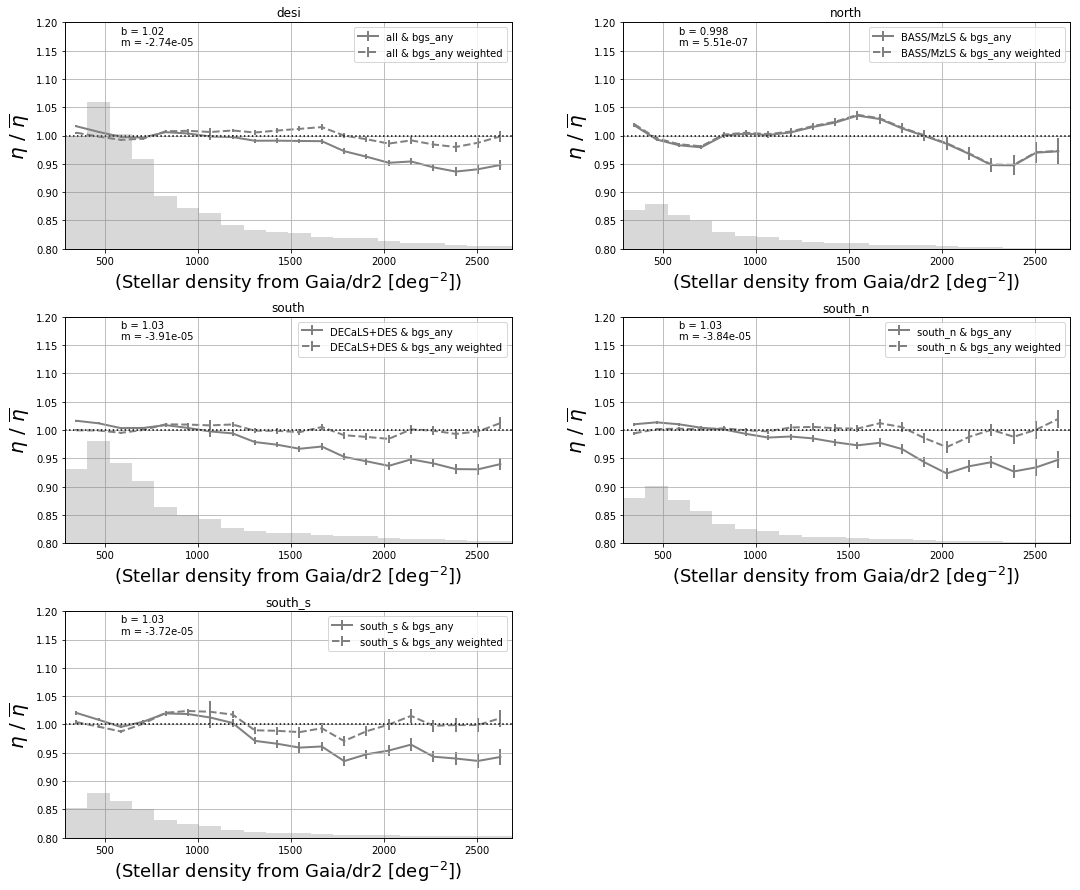

In [39]:
# get b and m coefficients for stellar density weights
fig    = plt.figure(figsize=(18,15))
gs     = gridspec.GridSpec(3,2,hspace=0.30,wspace=0.25)

isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
namesel = 'bgs_any'
syst='stardens'
ws = {}

for num, key in enumerate(['desi', 'north', 'south', 'south_n', 'south_s']):

#fig    = plt.figure(figsize=(9,5))
#gs     = gridspec.GridSpec(1,1,hspace=0.30,wspace=0.25)
    if key == 'desi': reg_ = 'all'
    else: reg_ = key
    
    b0, m0 = plot_sysdens(hpdicttmp=hpdict, namesels=[namesel], regs=[reg_], syst=syst, mainreg=isdesi, xlim=None, n=num, nx=20, 
             clip=True, denslims=False, ylab=True, weights=True, fig=fig, gs=gs, label=True, title=key, overbyreg=True)
    
    print(key, b0, m0)
    ws[key] = 1./((m0)*hpdict['stardens'] + b0)

fig.savefig('syst_w_weights_%s_%s_%s_%s.png' %(syst, dr, reg, namesel), bbox_inches = 'tight', pad_inches = 0)


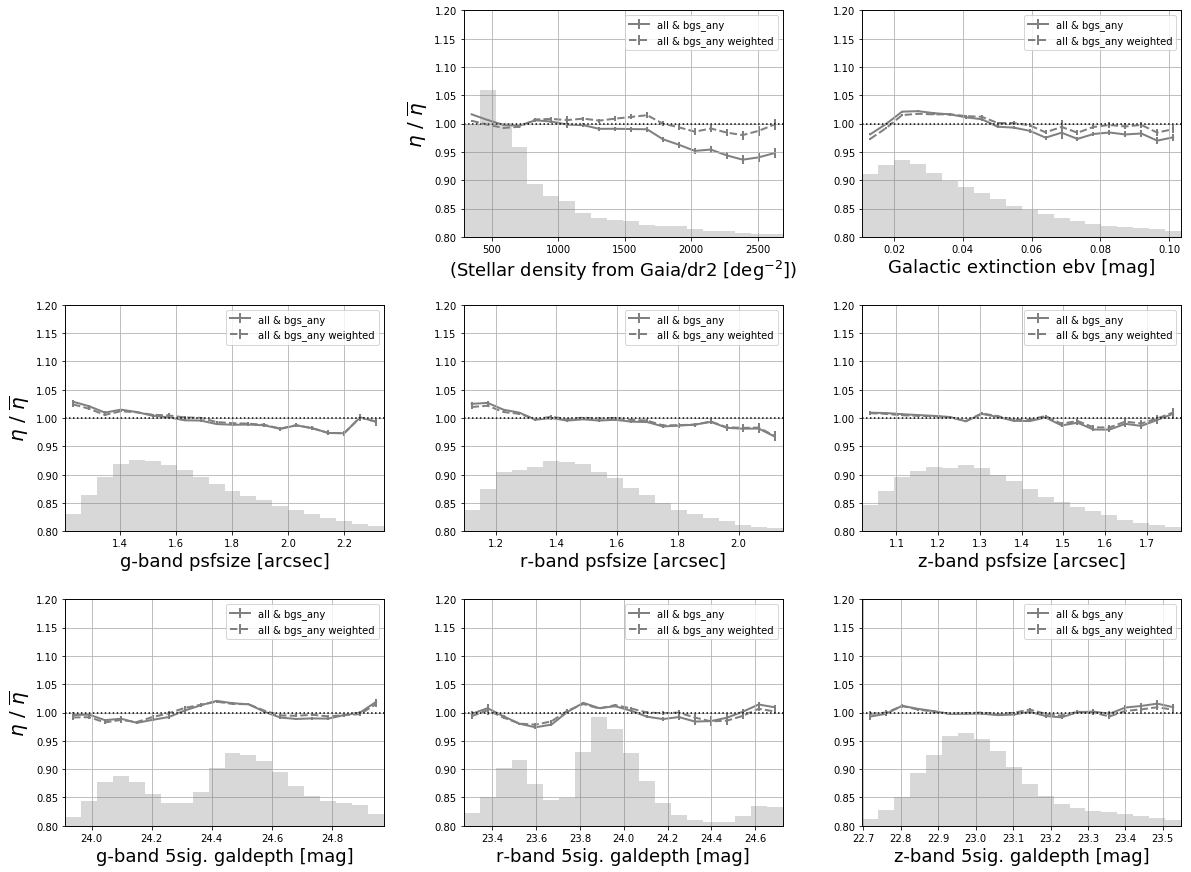

In [40]:
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']

fig    = plt.figure(figsize=(20,15))
gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
#ws = ws['desi']
namesel = 'bgs_any'
    
for i in range(9):
    
    if i == 0: continue
    if (i%3==0) or (i==1): ylab=True
    else: ylab = False
        
    plot_sysdens(hpdicttmp=hpdict, namesels=[namesel], regs=['all'], syst=systs[i-1], mainreg=isdesi, xlim=None, n=i, nx=20, 
             clip=True, denslims=False, ylab=ylab, weights=True, fig=fig, gs=gs, label=True, ws=ws['desi'])
    
fig.savefig('syst_w_weights_%s_%s_%s.png' %(dr, reg, namesel), bbox_inches = 'tight', pad_inches = 0)


In [76]:
hpdict['meandens_'+'bright'+'_'+'all']

838.3488281901134

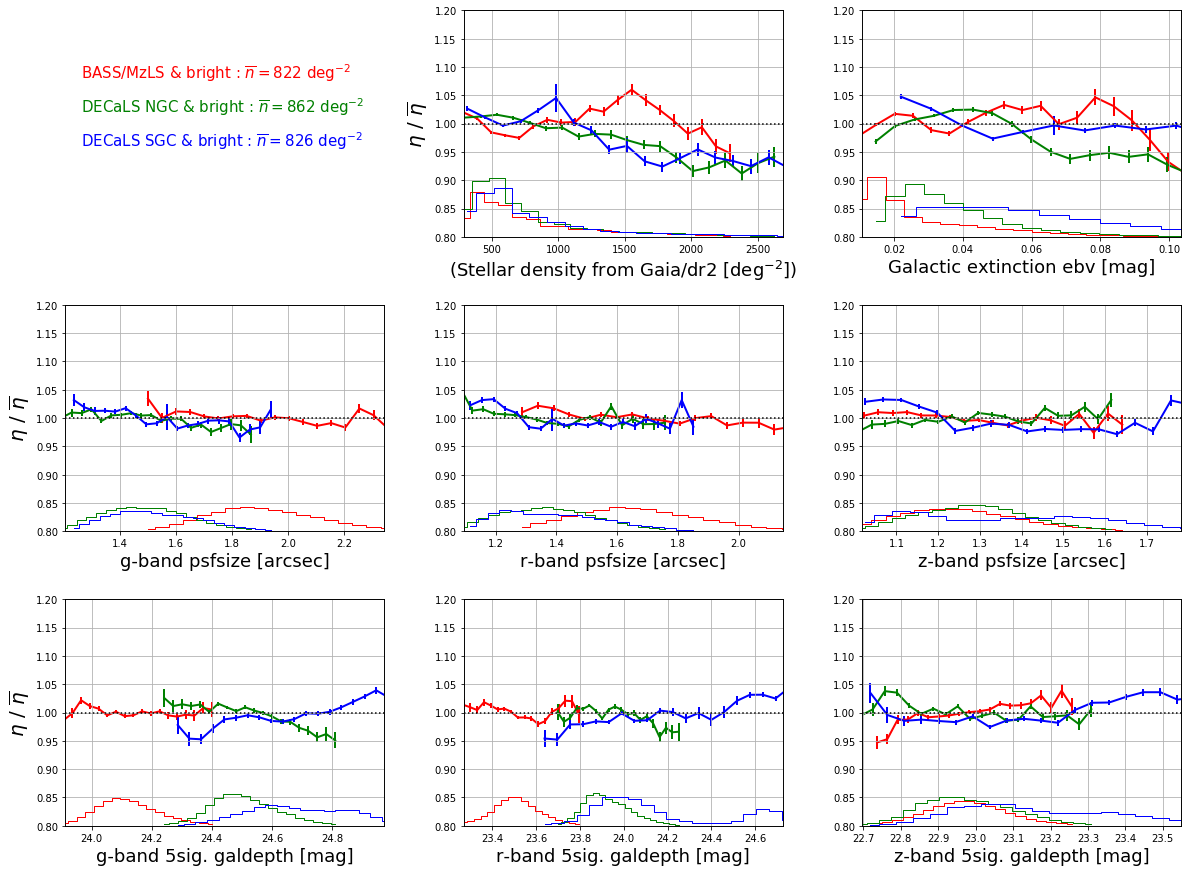

In [77]:
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']

fig    = plt.figure(figsize=(20,15))
gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
#ws = ws['desi']
namesel = 'bright'
#namesel = 'bgs_any'
regs = ['north', 'south_n', 'south_s']
cols       = ['r','g','b'] 
    
for i in range(9):
    
    if i == 0:
        axinfo = fig.add_subplot(gs[i])
        # infos
        axinfo.axis('off')
        #axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
        tmpy = 0.7
            #for regi,col in zip(regs,cols):
            #if reg == 'south':reg_ = 'DECaLS+DES'
            #else: reg_ = reg
        for reg_,col in zip(regs,cols):
            if reg_ == 'north': lab = 'BASS/MzLS'
            elif reg_ == 'south_s': lab = 'DECaLS SGC'
            elif reg_ == 'south_n': lab = 'DECaLS NGC'
            tmpstr = lab+' & '+namesel+' : '+r'$\overline{n}=$'+'%.0f'%hpdict['meandens_'+namesel+'_'+reg_]+r' deg$^{-2}$'
            axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=15,transform=axinfo.transAxes)
            tmpy  -= 0.15
    
    if i == 0: continue
    if (i%3==0) or (i==1): ylab=True
    else: ylab = False
        
    plot_sysdens(hpdicttmp=hpdict, namesels=[namesel], regs=regs, syst=systs[i-1], mainreg=isdesi, xlim=None, n=i, nx=20, 
             clip=True, denslims=False, ylab=ylab, weights=False, fig=fig, gs=gs, label=False, ws=None, cols=cols, overbyreg=True,
                    percentiles=[1,99])
    
fig.savefig('syst_%s_%s_%s.png' %(dr, reg, namesel), bbox_inches = 'tight', pad_inches = 0)


# Skymaps

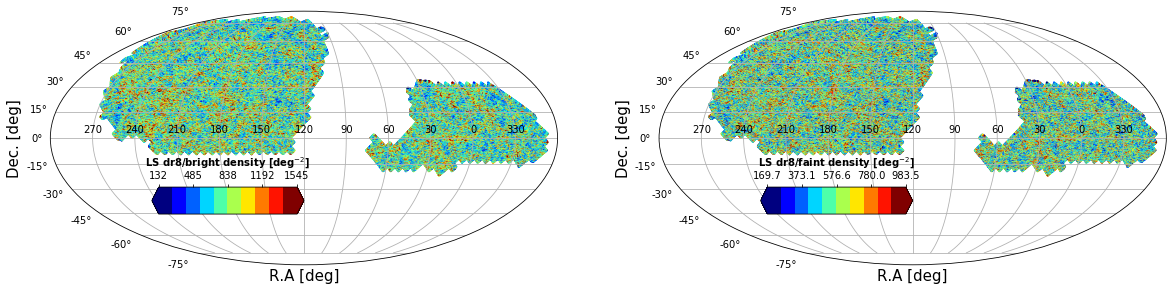

In [14]:
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(1,2)
    
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

if reg == 'desi': reg_ = 'all'
else: reg_ = reg
    
mollweide(hpdict=hpdict, namesel='bright', reg=reg_, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None)
mollweide(hpdict=hpdict, namesel='faint', reg=reg_, projection=projection, n=1, org=org, cm=cm, fig=fig, gs=gs, cval=None)

fig.savefig('skymap_dens_%s_%s.png' %(dr, reg), bbox_inches = 'tight', pad_inches = 0)


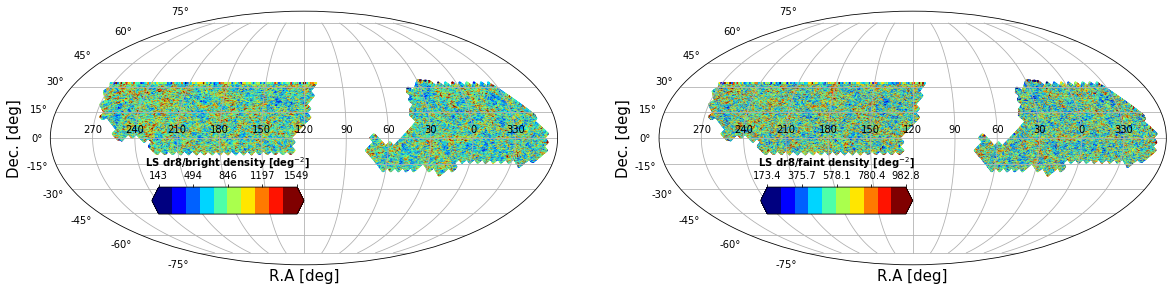

In [26]:
#with weights
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(1,2)
    
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)
    
mollweide(hpdict=hpdict, namesel='bright', reg='south', projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None, ws=ws['south'])
mollweide(hpdict=hpdict, namesel='faint', reg='south', projection=projection, n=1, org=org, cm=cm, fig=fig, gs=gs, cval=None, ws=ws['south'])

fig.savefig('skymap_dens_%s_%s_weighted_south.png' %(dr, reg), bbox_inches = 'tight', pad_inches = 0)


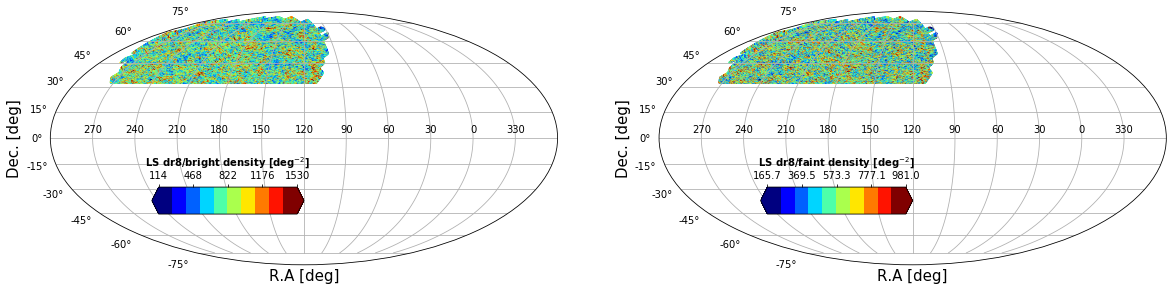

In [73]:
#with weights
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(1,2)
    
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)
    
mollweide(hpdict=hpdict, namesel='bright', reg='north', projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None, ws=ws['north'])
mollweide(hpdict=hpdict, namesel='faint', reg='north', projection=projection, n=1, org=org, cm=cm, fig=fig, gs=gs, cval=None, ws=ws['north'])

fig.savefig('skymap_dens_%s_%s_weighted_north.png' %(dr, reg), bbox_inches = 'tight', pad_inches = 0)


# Save BGS catalogue with DENSITY, STARDENS and WEIGHTS

In [44]:
# match associated target density for each object
import pandas as pd

%time s = pd.Series(extra['hppix'])
%time d = s.groupby(s).groups

DENS = np.zeros_like(cat['RA'])
WS_desi = DENS.copy()
WS_north = DENS.copy()
WS_south = DENS.copy()
WS_south_n = DENS.copy()
WS_south_s = DENS.copy()

STARDEN = np.zeros_like(cat['RA'])
hpdens = (hpdict['south_nbgs_any'] + hpdict['north_nbgs_any'] ) / (pixarea * hpdict['bgsfracarea'])
print(len(hpdens), len(WS_desi))
#
for npixid, catids in zip(d.keys(), d.values()):
    DENS[catids] = hpdens[npixid]
    STARDEN[catids] = hpdict['stardens'][npixid]
    WS_desi[catids] = ws['desi'][npixid]
    WS_north[catids] = ws['north'][npixid]
    WS_south[catids] = ws['south'][npixid]
    WS_south_n[catids] = ws['south_n'][npixid]
    WS_south_s[catids] = ws['south_s'][npixid]
    

CPU times: user 1.85 ms, sys: 12.7 ms, total: 14.6 ms
Wall time: 14.6 ms
CPU times: user 14.7 s, sys: 1.37 s, total: 16 s
Wall time: 15.8 s
786432 26695738


In [57]:
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
bgs_b = ((cat['BGSBITS'] & 2**(21)) != 0)
bgs_f = ((cat['BGSBITS'] & 2**(22)) != 0)

In [58]:
from astropy.table import Table

tab = Table()

for col in cat.dtype.names:
    tab[col] = cat[col]
    
for col in ['b','des','decals','north','desi','south']:
    tab[col] = extra[col]
    
tab['DENS'] = DENS
tab['WS_desi'] = WS_desi
tab['WS_north'] = WS_north
tab['WS_south'] = WS_south
tab['WS_south_n'] = WS_south_n
tab['WS_south_s'] = WS_south_s
tab['STARDEN'] = STARDEN
tab['bgs'] = bgs_any
tab['bgs_faint'] = bgs_f
tab['bgs_bright'] = bgs_b

if True:
# save astropy table as npy file
    dest = '/global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_3.2'
    np.save(dest, tab)

In [59]:
#give the right permissions
!chgrp -R desi /global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_3.2.npy
!chmod -R g+rX /global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_3.2.npy

c_ran = SkyCoord(randoms['RA']*units.degree,randoms['DEC']*units.degree, frame='icrs')
galb_ran = c_ran.galactic.b.value # galb coordinate
print('GAL b DONE...')

# Save RANDOMS for BGS with STARDENS

In [46]:
# match associated target density for each object
import pandas as pd

s = pd.Series(ran_ex['hppix'])
d = s.groupby(s).groups

STARDEN_ran = np.zeros_like(randoms['RA'])

#
for npixid, catids in zip(d.keys(), d.values()):
    STARDEN_ran[catids] = hpdict['stardens'][npixid]


In [17]:
#
tabran = Table()

mask = (rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs'])

tabran['RA'], tabran['DEC'] = randoms['RA'][mask], randoms['DEC'][mask]
tabran['MASKBITS'] = randoms['MASKBITS'][mask]

for col in ['b','des','decals','north','desi','south']:
    tabran[col] = ran_ex[col][mask]
    
tabran['STARDEN'] = STARDEN_ran[mask]
    
# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/pauline/randoms_dr8_N3_pauline_3.0'
np.save(dest, tabran)

# Save GAMA matched for above BGS catalogues

In [5]:
cat = np.load('/global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_3.1.npy')

In [2]:
gama_ = fitsio.read('/global/cscratch1/sd/qmxp55/TilingCatv46.fits', ext=1)
# get only good quality gama objects
gama = gama_[(gama_['SURVEY_CLASS'] >= 4) & (gama_['NQ'] >= 3)]

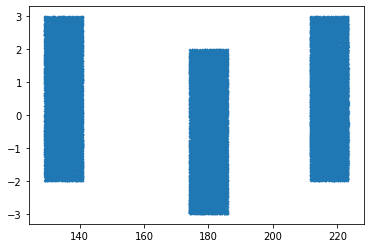

In [7]:
plt.scatter(gama['RA'], gama['DEC'], s=0.1)

In [3]:
def get_isgama(ra, dec):
    
    keep = np.zeros_like(ra, dtype='?')

    keep |= ((ra > 174.) & (ra < 186.) & (dec > -3.) & (dec < 2.)) #G12
    keep |= ((ra > 211.5) & (ra < 223.5) & (dec > -2.) & (dec < 3.)) #G15
    keep |= ((ra > 129.) & (ra < 141.) & (dec > -2.) & (dec < 3.)) #G09
    
    return keep

In [9]:
for col in gama.dtype.names:
    print(col)

CATAID
OBJID
RA
DEC
FIBERMAG_R
R_PETRO
U_MODEL
G_MODEL
R_MODEL
I_MODEL
Z_MODEL
SURVEY_CODE
Z
NQ
NQ2_FLAG
SPECID
VEL_ERR
NUM_GAMA_SPEC
R_SB
SG_SEP
SG_SEP_JK
K_AUTO
RADIO_FLUX
HATLAS_FLAG
AREA_FLAG
TARGET_FLAGS
SURVEY_OLDCLASS
SURVEY_CLASS
PRIORITY_CLASS
NEIGHBOUR_CLASS
TC_V11_ID
MASK_IC_10
MASK_IC_12
VIS_CLASS
VIS_CLASS_USER


In [36]:
def match(cat=None, gama=None):
    
    # matching LS8 with gama stars and galaxies
    idx20, idx10, d2d0, d_ra0, d_dec0 = search_around(cat['RA'], cat['DEC'], 
                                                                gama['RA'], gama['DEC'], search_radius=1)
    
    tabGAMA = Table()
    
    cat_gama = np.zeros_like(cat['RA'], dtype='?') #dr8 that match with gama
    cat_gama2 = np.full_like(cat['RA'], np.nan) #z from gama
    cat_gama3 = np.full_like(cat['RA'], np.nan, dtype=str) #z from gama
    
    cat_gama[idx20.tolist()] = True
    tabGAMA['inGAMA'] = cat_gama

    for col in gama.dtype.names:
        
        print(col)
        #float, int, str, list, dict, tuple
        if isinstance(gama[col][0], (str)): cat0 = cat0 = cat_gama3.copy()
        else: cat0 = cat_gama2.copy()
            
        cat0[idx20.tolist()] = gama[col][idx10]
        tabGAMA[col] = cat0
    
    return tabGAMA


In [15]:
from io_ import search_around

In [37]:
#match catalogue with GAMA
Agama = 180.
#mask = cat['RMAG'] < 15
tabGAMA = match(cat=cat, gama=gama)

gamastars8 = (tabGAMA['Z'] < 0.002) & (tabGAMA['Z'] > 0) & (tabGAMA['inGAMA'])
gamagal8 = (tabGAMA['Z'] > 0.002) & (tabGAMA['inGAMA'])

print('GAMA in DR8: \t %.3f(stars) \t %.3f(galaxies)' %(np.sum(gamastars8)/Agama,np.sum(gamagal8)/Agama))


175550 nearby objects
CATAID
OBJID
RA
DEC
FIBERMAG_R
R_PETRO
U_MODEL
G_MODEL
R_MODEL
I_MODEL
Z_MODEL
SURVEY_CODE
Z
NQ
NQ2_FLAG
SPECID
VEL_ERR
NUM_GAMA_SPEC
R_SB
SG_SEP
SG_SEP_JK
K_AUTO
RADIO_FLUX
HATLAS_FLAG
AREA_FLAG
TARGET_FLAGS
SURVEY_OLDCLASS
SURVEY_CLASS
PRIORITY_CLASS
NEIGHBOUR_CLASS
TC_V11_ID
MASK_IC_10
MASK_IC_12
VIS_CLASS
VIS_CLASS_USER
GAMA in DR8: 	 0.200(stars) 	 974.844(galaxies)


In [38]:
# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/pauline/GAMA_matched_dr8_3.1'
np.save(dest, tabGAMA)

## stardens catalogue
GAIA objects that compose the stellar density systematic

        # ADM restrict to subset of point sources.
        ra, dec = gobjs["RA"], gobjs["DEC"]
        gmag = gobjs["PHOT_G_MEAN_MAG"]
        excess = gobjs["ASTROMETRIC_EXCESS_NOISE"]
        point = (excess == 0.) | (np.log10(excess) < 0.3*gmag-5.3)
        grange = (gmag >= 12) & (gmag < 17)
        w = np.where(point & grange)

In [48]:
maskbitsourcesfile = '/global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_maskbitsource.npy'
hppixmasksourcesfile = '/global/cscratch1/sd/qmxp55/BS_mask/hppix_dr8_masksources.npy'

maskbitsources = np.load(maskbitsourcesfile)
hppixmasksources = np.load(hppixmasksourcesfile)

In [55]:
def getStarDenSources(df):
    
    #GAIA objects only
    keep = np.ones_like(df['RA'], dtype=bool)
    
    keep &= df['REF_CAT'] == b'G2'
    keep &= (df['G'] >= 12) & (df['G'] < 17)
    point = (df['AEN'] == 0.) | (np.log10(df['AEN']) < 0.3*df['G']-5.3)
    mask = (point) & (keep)
    print(np.sum(mask))
    #
    return mask

In [56]:
stardens = getStarDenSources(maskbitsources)

18709321


In [62]:
maskbitsourcesinregfile = '/global/cscratch1/sd/qmxp55/BS_mask/inREGIONS_dr8_masksources.npy'
maskbitsourcesinreg = np.load(maskbitsourcesinregfile)

In [66]:
#
tabstarden = Table()

for col in ['RA', 'DEC', 'G']:
    tabstarden[col] = maskbitsources[col][stardens]
    
for col in ['des', 'decals', 'north', 'desi']:
    tabstarden[col] = maskbitsourcesinreg[col][stardens]
tabstarden['south'] = (maskbitsourcesinreg['des'][stardens]) | (maskbitsourcesinreg['decals'][stardens])

    
# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/pauline/GAIA_12_17_pointsources'
np.save(dest, tabstarden)

In [72]:
set(maskbitsources['REF_CAT'][stardens])

{b'G2'}

# Sanity checks with some skyplots...

Text(0, 0.5, 'Dec.')

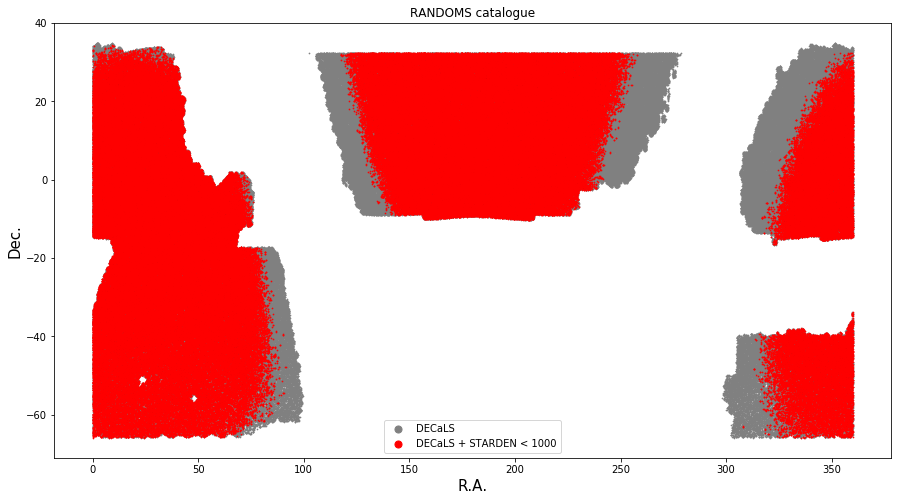

In [24]:
plt.figure(figsize=(15,8))

mask2 = tabran['STARDEN'] < 1000
maskn = (tabran['north']) & (tabran['desi'])
masks_n = (tabran['south']) & (tabran['desi']) & (tabran['b'] > 0)
masks_s = (tabran['south']) & (tabran['desi']) & (tabran['b'] < 0)
N = 500

#plt.scatter(tabran['RA'][::N], tabran['DEC'][::N], s=0.5, c='gray', label='all')
#plt.scatter(tabran['RA'][masks_n][::N], tabran['DEC'][masks_n][::N], s=0.5, c='r', label='DECaLS NGC = desi & south & galb > 0')
#plt.scatter(tabran['RA'][masks_s][::N], tabran['DEC'][masks_s][::N], s=0.5, c='orange', label='DECaLS SGC = desi & south & galb < 0')
#plt.scatter(tabran['RA'][maskn][::N], tabran['DEC'][maskn][::N], s=0.5, c='k', label='BASS/MzLS = desi & north')

#sanity check for STARDEN
plt.scatter(tabran['RA'][(tabran['south'])][::N], tabran['DEC'][(tabran['south'])][::N], s=0.5, c='gray', label='DECaLS')
plt.scatter(tabran['RA'][(tabran['south']) & (mask2)][::N], tabran['DEC'][(tabran['south']) & (mask2)][::N], s=0.5, c='r', label='DECaLS + STARDEN < 1000')
#plt.axhline(dec_resol_ns, lw=2, c='b', ls='--')

plt.title('RANDOMS catalogue', size=20)

lgnd = plt.legend()
[handle.set_sizes([50]) for handle in lgnd.legendHandles]

plt.xlabel(r'R.A.', size=15)
plt.ylabel(r'Dec.', size=15)


Text(0, 0.5, 'Dec.')

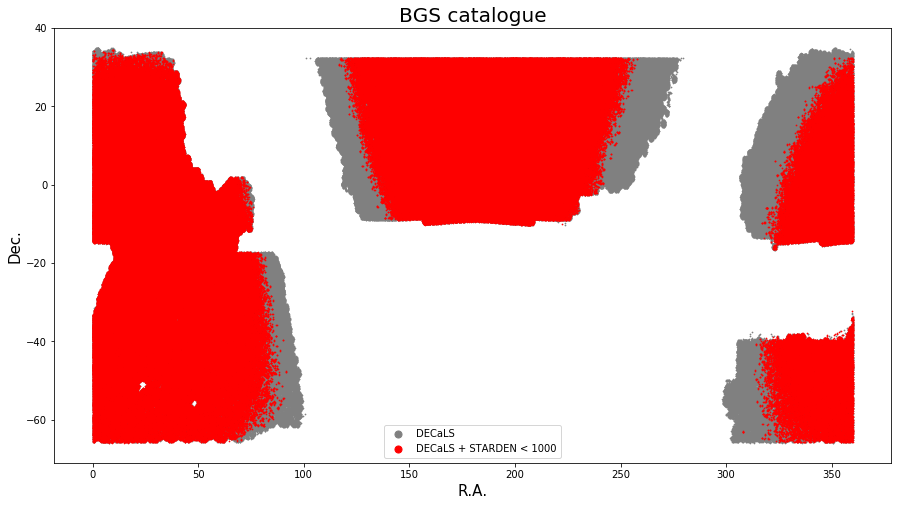

In [47]:
plt.figure(figsize=(15,8))

N = 30
#plt.scatter(tab['RA'][::1000], tab['DEC'][::1000])
mask2 = tab['STARDEN'] < 1000
maskn = (tab['north']) & (tab['desi'])
masks_n = (tab['south']) & (tab['desi']) & (tab['b'] > 0)
masks_s = (tab['south']) & (tab['desi']) & (tab['b'] < 0)

#plt.scatter(tab['RA'][::N], tab['DEC'][::N], s=0.5, c='gray', label='all')
#plt.scatter(tab['RA'][masks_n][::N], tab['DEC'][masks_n][::N], s=0.5, c='r', label='DECaLS NGC = desi & south & galb > 0')
#plt.scatter(tab['RA'][masks_s][::N], tab['DEC'][masks_s][::N], s=0.5, c='orange', label='DECaLS SGC = desi & south & galb < 0')
#plt.scatter(tab['RA'][maskn][::N], tab['DEC'][maskn][::N], s=0.5, c='k', label='BASS/MzLS = desi & north')
#plt.axhline(dec_resol_ns, lw=2, c='b', ls='--')

#sanity check for STARDEN
plt.scatter(tab['RA'][(tab['south'])][::N], tab['DEC'][(tab['south'])][::N], s=0.5, c='gray', label='DECaLS')
plt.scatter(tab['RA'][(tab['south']) & (mask2)][::N], tab['DEC'][(tab['south']) & (mask2)][::N], s=0.5, c='r', label='DECaLS + STARDEN < 1000')


plt.title('BGS catalogue', size=20)

lgnd = plt.legend()
[handle.set_sizes([50]) for handle in lgnd.legendHandles]

plt.xlabel(r'R.A.', size=15)
plt.ylabel(r'Dec.', size=15)


In [61]:
tab.dtype.names

('TYPE',
 'RA',
 'DEC',
 'GMAG',
 'RMAG',
 'ZMAG',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'RFIBERMAG',
 'REF_CAT',
 'REF_ID',
 'G',
 'AEN',
 'MASKBITS',
 'FLUX_R',
 'BGSBITS',
 'b',
 'des',
 'decals',
 'north',
 'desi',
 'south',
 'DENS',
 'WS_desi',
 'WS_north',
 'WS_south',
 'WS_south_n',
 'WS_south_s',
 'STARDEN',
 'bgs',
 'bgs_faint',
 'bgs_bright')

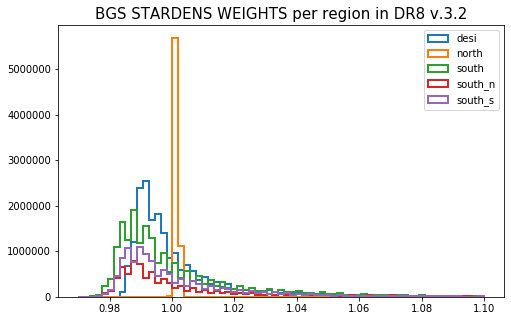

In [64]:
#
plt.figure(figsize=(8, 5))
bins = np.linspace(.97, 1.10, 70)
plt.title('BGS STARDENS WEIGHTS per region in DR8 v.3.2', size=15)
for i in ['desi', 'north', 'south', 'south_n', 'south_s']:
    
    if i == 'south_n': mask = (tab['b'] > 0) & (tab['south'])
    elif i == 'south_s': mask = (tab['b'] < 0) & (tab['south'])
    else: mask = tab[i]
    
    plt.hist(tab['WS_'+i][mask], bins=bins, histtype='step', lw=2, label=i)
    plt.legend()


In [67]:
stars = np.load('/global/cscratch1/sd/qmxp55/pauline/GAIA_12_17_pointsources.npy')

In [68]:
stars.dtype.names

('RA', 'DEC', 'G', 'des', 'decals', 'north', 'desi', 'south')

Text(0, 0.5, 'Dec.')

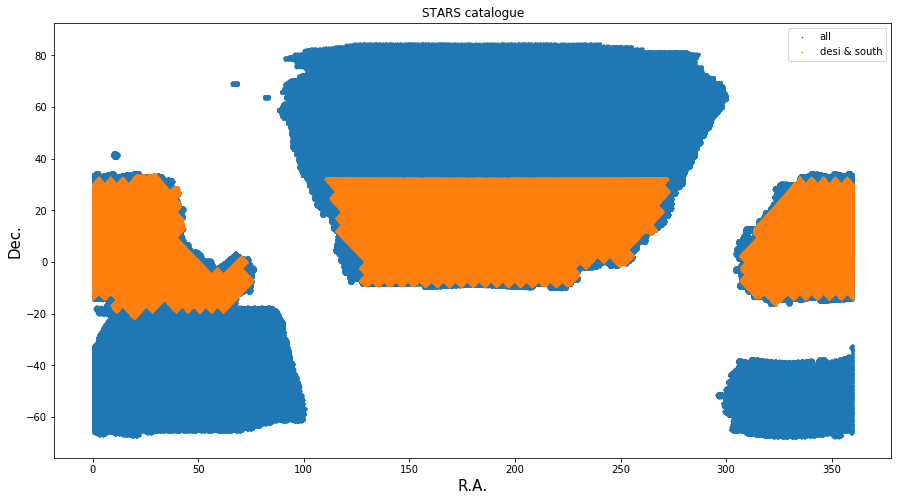

In [69]:
plt.figure(figsize=(15,8))

#plt.scatter(tab['RA'][::1000], tab['DEC'][::1000])
mask = (stars['south']) & (stars['desi'])
#plt.scatter(tab['RA'][tab['north']][::1000], tab['DEC'][tab['north']][::1000], label='north')
plt.scatter(stars['RA'][::5], stars['DEC'][::5], s=0.5, label='all')
#plt.scatter(stars['RA'][stars['issouth']][::10], stars['DEC'][stars['issouth']][::10], s=0.5, label='south')
plt.scatter(stars['RA'][mask][::5], stars['DEC'][mask][::5], s=0.5, label='desi & south')

plt.title('STARS catalogue')

plt.legend()
plt.xlabel(r'R.A.', size=15)
plt.ylabel(r'Dec.', size=15)


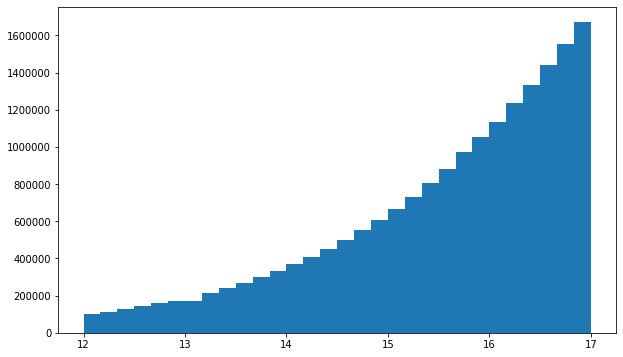

In [70]:
plt.figure(figsize=(10,6))
plt.hist(stars['G'], 30)
plt.show()

# DEV ZONE...

In [19]:
dr82 = np.load('/global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_2.0.npy')

In [22]:
dr82_n = np.load('/global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_north_pauline_2.0.npy')

In [23]:
dr82_s = np.load('/global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_south_pauline_2.0.npy')

In [20]:
dr83 = np.load('/global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_3.0.npy')

In [21]:
dr831 = np.load('/global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_3.1.npy')

In [18]:
def plot(dr, N):
    
    plt.figure(figsize=(18, 9))
    plt.scatter(dr['RA'][dr['north']][::N], dr['DEC'][dr['north']][::N], s=1, color='r', label='NORTH')
    plt.scatter(dr['RA'][dr['south']][::N], dr['DEC'][dr['south']][::N], s=1, color='b', label='SOUTH')
    plt.legend()

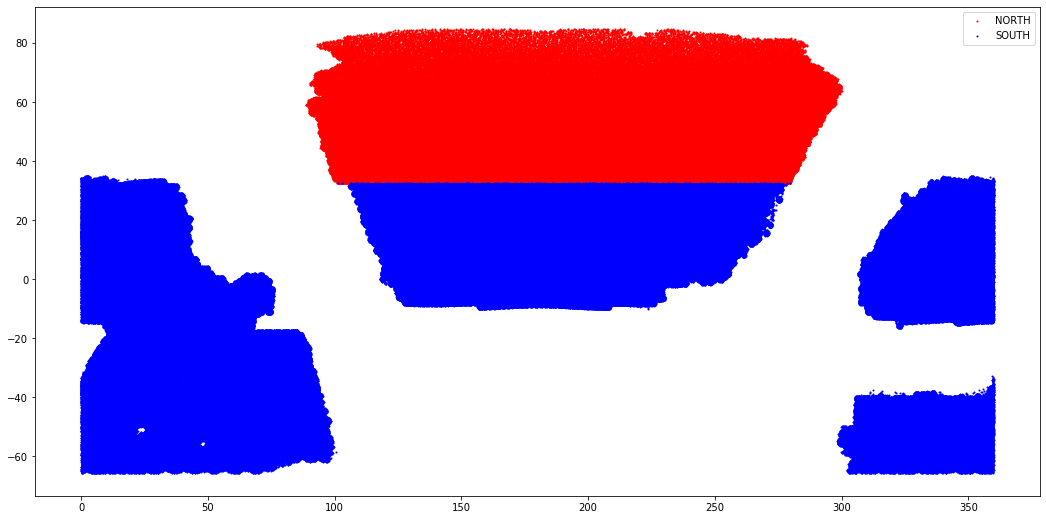

In [19]:
plot(dr=dr831, N=30)

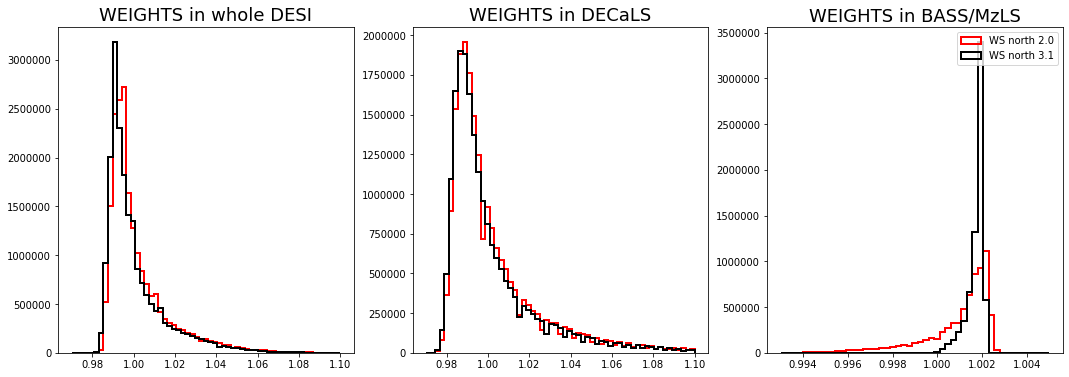

In [56]:
#
plt.figure(figsize=(18, 6))
bins = np.linspace(.97, 1.10, 60)
#for i in ['desi', 'north', 'south']:
    
plt.subplot(1, 3, 1)
plt.title('WEIGHTS in whole DESI', size=18)
plt.hist(dr82['WS'][dr82['desi']], bins=bins, histtype='step', lw=2, color='r', label='WS desi 2.0')
#plt.hist(dr83['WS'], bins=bins, histtype='step', lw=2, label='WS desi 3.0')
plt.hist(WS_desi[extra['desi']], bins=bins, histtype='step', lw=2, color='k', label='WS desi 3.1')

plt.subplot(1, 3, 2)
plt.title('WEIGHTS in DECaLS', size=18)
plt.hist(dr82_s['WS'][dr82_s['south']], bins=bins, histtype='step', lw=2, color='r', label='WS south 2.0')
plt.hist(WS_south[extra['south']], bins=bins, histtype='step', lw=2, color='k', label='WS south 3.1')

plt.subplot(1, 3, 3)
plt.title('WEIGHTS in BASS/MzLS', size=18)
bins = np.linspace(.993, 1.005, 50)
plt.hist(dr82_n['WS'][dr82_n['north']], bins=bins, histtype='step', lw=2, color='r', label='WS north 2.0')
plt.hist(WS_north[extra['north']], bins=bins, histtype='step', lw=2, color='k', label='WS north 3.1')

plt.legend()

### Below code is for desitarget outputs only

In [ ]:
cols = ['RA', 'DEC', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'FIBERFLUX_R', 'MW_TRANSMISSION_R', 
                'MW_TRANSMISSION_G', 'MW_TRANSMISSION_Z','MASKBITS', 'REF_CAT', 'REF_ID', 
                    'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE', 'FRACFLUX_G', 
                        'FRACFLUX_R', 'FRACFLUX_Z', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z',
                             'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'MORPHTYPE', 'FLUX_IVAR_R', 'FLUX_IVAR_G',
                                   'FLUX_IVAR_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z']

In [33]:
#
from astropy.table import Table

tab = Table()
for col in cols:
    if (col[:4] == 'FLUX') & (col[:9] != 'FLUX_IVAR'): tab[col[-1:]+'MAG'] = flux_to_mag(cat['FLUX_'+col[-1:]]/cat['MW_TRANSMISSION_'+col[-1:]])
    elif col[:2] == 'MW': continue
    elif col == 'FIBERFLUX_R': tab['RFIBERMAG'] = flux_to_mag(cat[col]/cat['MW_TRANSMISSION_R'])
    elif col == 'GAIA_PHOT_G_MEAN_MAG': tab['G'] = cat[col]
    elif col == 'GAIA_ASTROMETRIC_EXCESS_NOISE': tab['AEN'] = cat[col]
    else: tab[col] = cat[col]
        
for key in catinregs.keys():
    tab[key] = catinregs[key]
    
tab['FLUX_R'] = cat['FLUX_R']
tab['DENS'] = DENS
tab['WS'] = WS
tab['bgs'] = bgs
tab['bgs_faint'] = bgsf
tab['bgs_bright'] = bgsb
tab['galb'] = galb

# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_2.0'
np.save(dest, tab)
